# Anomaly Detection in System Call Traces

This notebook demonstrates a methodology for detecting anomalies in system call traces using a combination of statistical and machine learning techniques. The primary goal is to distinguish between "clean" and "infected" traces. 

Note: there is an important gap between this pipeline's objective and Subcom's requirements. This pipeline runs a composition of machine learning and statistical techniques on the entire trace file of an application to determine whether it's a deviation from the trained model of "a clean process". Subcom requires a pipeline capable of determining this **online** on a habitual and context-dependent basis, while minimizing false positives.

The pipeline has largely been implemented based on this paper: https://maggi.cc/publication/frossi_hybridsyscalls_2009/frossi_hybridsyscalls_2009.pdf

Choice of clustering and temporal models can be changed. The central principle of the paper involves feature engineering system call information to obtain information richer than just the "syscall names/indices", and using the high-dimensional feature set to create informative sub-clusters for each syscall. The typical temporal pipeline can then be employed upon these clusters, treating them as observed states. The paper proposes additional enhancements relevant to the domain: **SOMs for pathname similarity, Buffer overflow detection by modelling string arg lengths, DoS detection with edge traversal frequencies.**

*This notebook is experimental and has not been refined for production/documentation*

In [1]:
import time
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from scipy.signal import savgol_filter

In [2]:
from project.utils import process_trace
from project.trace_parser import list_files_in_folder,get_trace_text,parse_trace_text
from project.preprocessing import padding
from project.buffer_overflow import init_strlen_distribution, detect_str_outlier
from project.string_anomaly_som import init_som, detect_string_anomaly_som
from project.clustering import init_cluster_mapping, features_to_states
from project.sequence_model import get_transition_probs
from project.dos_detection import init_edge_frequencies
from project.anomaly_detection import sequence_probability, initialize_pca
from project.segmentation import soe, autocorrelation, segment_sequence, process_segments, longest_common_subsequence

## Data Retrieval

In this section, we retrieve and parse the system call traces from the specified folders. The traces are divided into "clean" and "infected" categories.

In [3]:
traces_path = "/Users/vismay/PycharmProjects/subcom_pipeline_research/Traces/"

clean_folder = traces_path+"clean/"
trace_files_clean = list_files_in_folder(clean_folder)

infected_folder = traces_path+"infected/"
trace_files_infected = list_files_in_folder(infected_folder)

In [4]:
clean_trace_text_train = get_trace_text(clean_folder, trace_files_clean[:int(.75*len(trace_files_clean))])
clean_trace_text_test = get_trace_text(clean_folder, trace_files_clean[int(.75*len(trace_files_clean)):])
infected_trace_text = get_trace_text(infected_folder, trace_files_infected)

In [5]:
clean_syscall_info_train = parse_trace_text(clean_trace_text_train)
clean_syscall_info_test = parse_trace_text(clean_trace_text_test)
infected_syscall_info = parse_trace_text(infected_trace_text)

In [6]:
infected_syscall_info[0]

['clock_gettime', 'CLOCK_MONOTONIC', '{249453', '99629866}']

## Data Preprocessing

Here, we convert the parsed system call information into feature vectors suitable for the employed techniques.

In [7]:
unique_syscall_types = list(set([info[0] for info in 
                                 clean_syscall_info_train + clean_syscall_info_test + infected_syscall_info]))

syscall_type_mapping = {syscall_type: i for i, syscall_type in enumerate(unique_syscall_types)}

padded_feature_vectors = []
training_str_args = []
max_len = 0

for clean_file in trace_files_clean[:int(.75*len(trace_files_clean))]:
    padded_feature_vectors_i, str_args_i, pad_len = process_trace(clean_folder, clean_file, syscall_type_mapping)
    max_len = max(pad_len, max_len)
    padded_feature_vectors.extend(padded_feature_vectors_i)
    training_str_args.extend(str_args_i)
    
padded_feature_vectors = padding(padded_feature_vectors, max_len)

### Modelling string argument lengths for buffer overflow detection

In [10]:
flattened_str_args = [arg for trace_str_args in training_str_args for arg in trace_str_args]
init_strlen_distribution(flattened_str_args)

Mean string length: 39.76; standard deviation 28.19


In [11]:
### Example use-case; output = `True` if outlier

detect_str_outlier("/Users/vismay/desktop/textbooks/Algorithmic Trading with Interactive Brokers.pdf")

False

## Self-Organizing Map for Pathname & Escape-Sequence Similarity

A Self-Organizing Map (SOM) is used to encode and visualize the similarity of pathnames and escape sequences found in syscall string arguments

=> Initializing Self-Organizing Map
=> Shape of Map Weights: (10, 10, 5)
=> Calculating threshold distance for anomaly detection
=> Threshold distance: 0.493397824678508


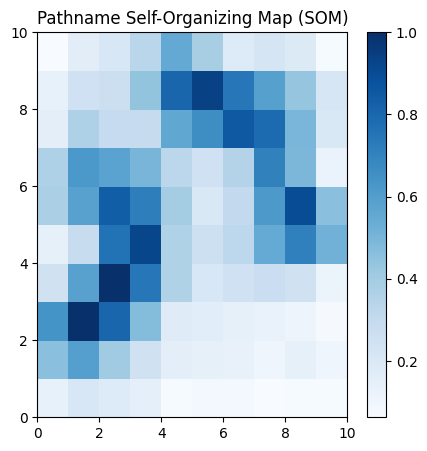

In [12]:
pathnames = list(filter(lambda s: "/" in s, flattened_str_args))
init_som(pathnames)

In [13]:
### Example use-case; output = `True` if anomaly

string_arr = ['/Users/vismay/PycharmProjects/subcom_internship/Traces/subcom_internship/Traces/']
print(detect_string_anomaly_som(string_arr))

string_arr = ['somuser/somedir/someapk/somefile']
print(detect_string_anomaly_som(string_arr))

False
False


## Syscall Probabilistic Subclustering

Syscall feature vectors are clustered using Gaussian Mixture Models (GMM) or K-Means to create a probabilistic model for syscall behavior.

In [14]:
syscall_to_cluster = init_cluster_mapping(padded_feature_vectors)

=> Initializing cluster mapping
=> Done!


In [15]:
training_states = features_to_states(padded_feature_vectors)

## Markov Chain Construction

A Markov Chain is constructed to model the transitions between syscall states (temporal dependencies)

In [16]:
n = 6

In [17]:
transition_probabilities = get_transition_probs(training_states, n)

## Dos Detection with Edge Traversal Frequencies

We analyze the frequencies of edge traversals in the Markov Chain to detect potential DoS attacks. The transition probabilities matrix used for training the markov chain is seperate from the ones used to train Dos Detection. In the markov chain training, we create a transition probability matrix for the entire training corpus (all trace text from designated clean training trace files). For DoS detection, we construct a transition probability matrix for each training clean trace in isolation and compute the frequency of edge traversals to obtain outliers by fitting a beta distribution.

In [18]:
init_edge_frequencies(trace_files_clean, clean_folder, n, syscall_type_mapping)

Edge traversal training: 25% complete
Edge traversal training: 50% complete
Edge traversal training: 75% complete
Edge traversal training: 100% complete


## Segmentation by Autocorrelation

In [19]:
# encoder = LabelEncoder()
training_states_str = [str(ts) for ts in training_states]
# encoded_training_states = encoder.fit_transform(training_states_str)
encoded_data = []

for clean_file in trace_files_clean[:int(.75*len(trace_files_clean))]:   
    feature_vectors, strargs, _ = process_trace(clean_folder, clean_file, syscall_type_mapping)
    syscall_idx = [fv[0] for fv in feature_vectors]
    # states_sequence = features_to_states(feature_vectors)
    # states_sequence = [str(state) for state in states_sequence]
    encoded_data.append(syscall_idx)

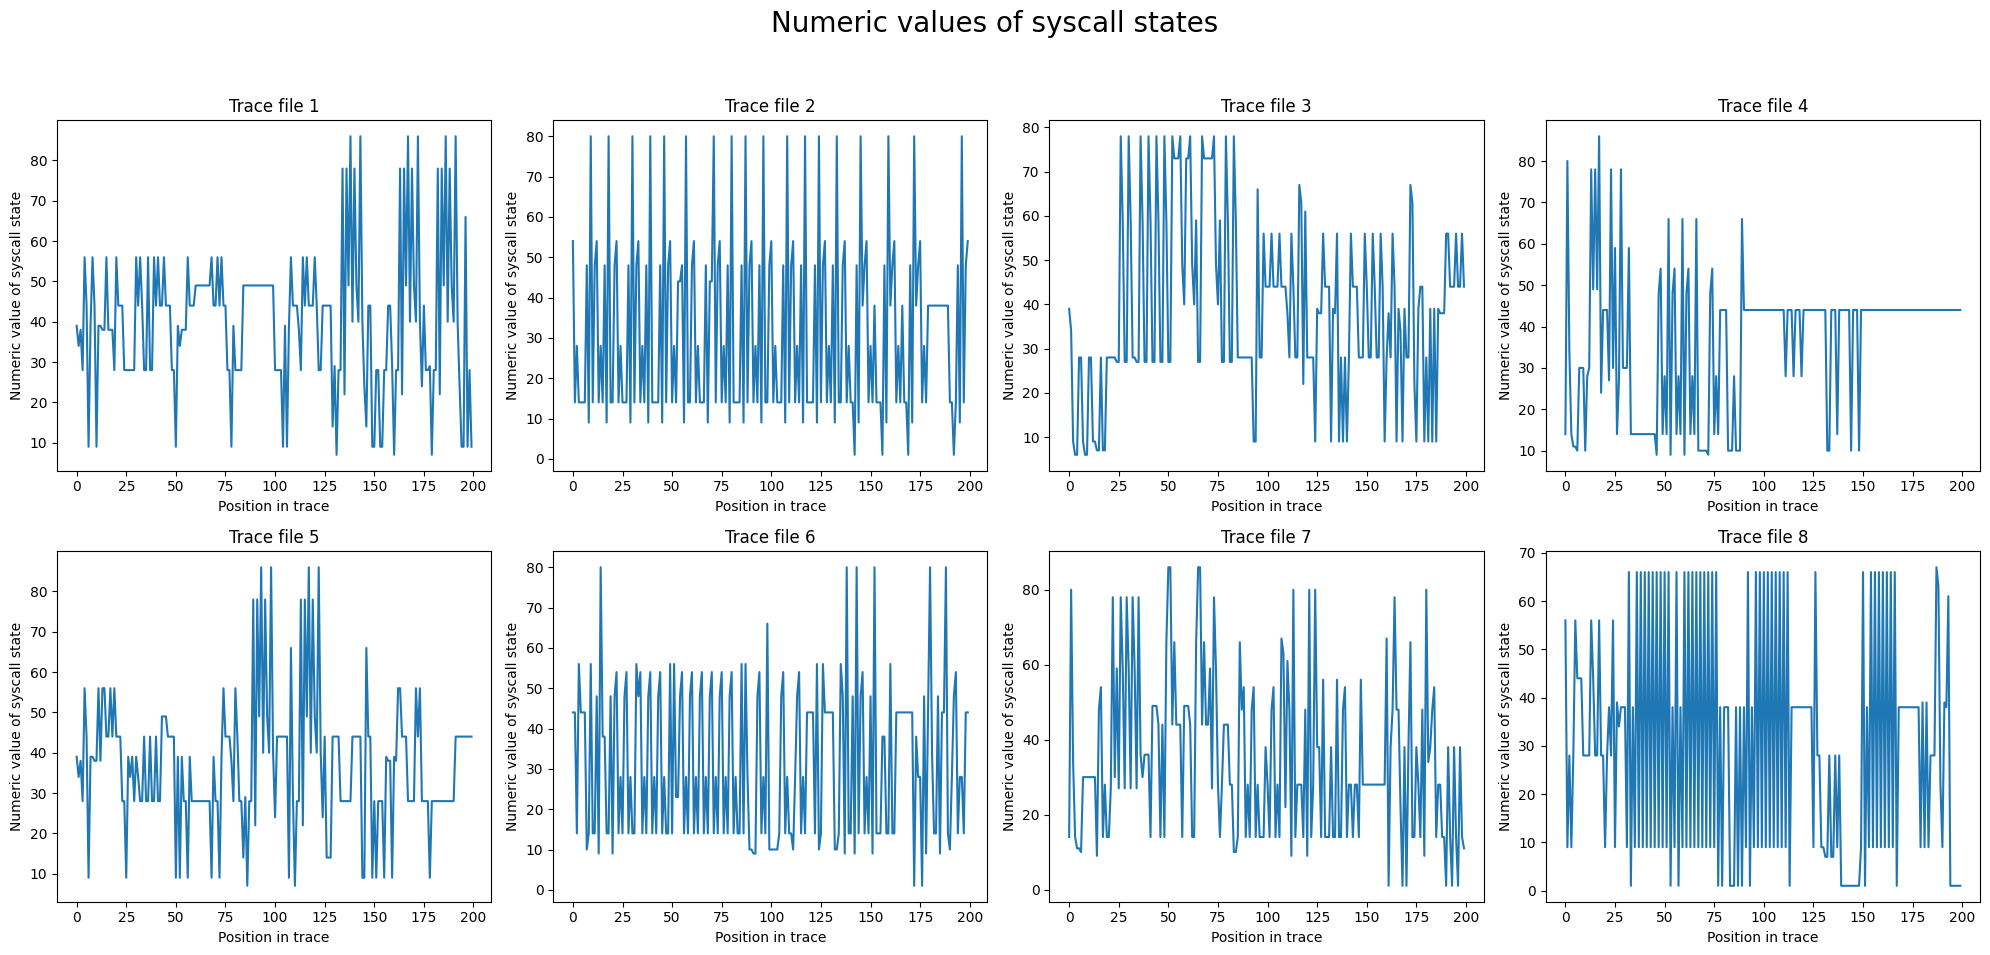

In [20]:
plt.figure(figsize=(20, 10))

for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.plot(encoded_data[i][:200])
        plt.xlabel("Position in trace")
        plt.ylabel("Numeric value of syscall state")
        plt.title(f"Trace file {i+1}")
    
plt.suptitle("Numeric values of syscall states", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

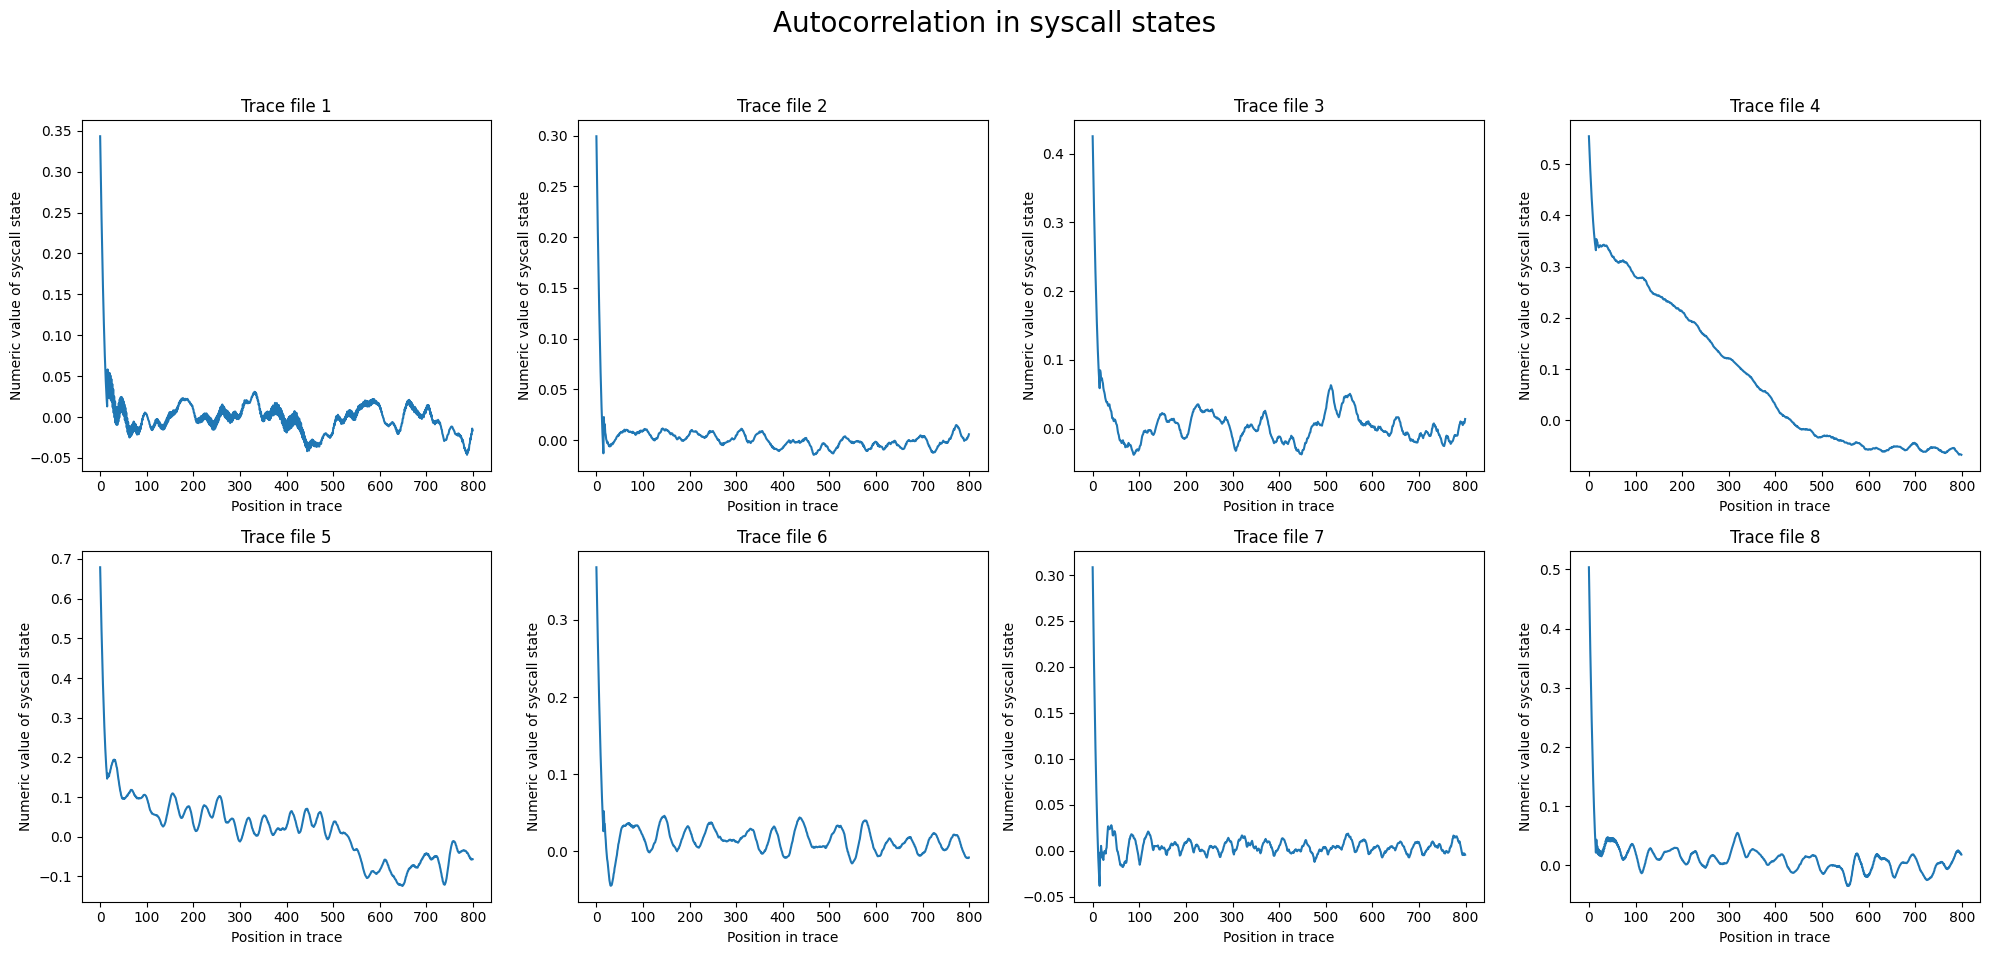

In [21]:
plt.figure(figsize=(20, 10))

for i in range(8):
        plt.subplot(2, 4, i+1)
        acf = autocorrelation(encoded_data[i])
        acf = savgol_filter(acf, window_length=31, polyorder=2)
        plt.plot(acf[100:])
        plt.xlabel("Position in trace")
        plt.ylabel("Numeric value of syscall state")
        plt.title(f"Trace file {i+1}");
    
plt.suptitle("Autocorrelation in syscall states", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [92]:
# # IN PROGRESS

# import collections

# segments = []
# for trace in encoded_data:
#     trace_segments = soe(trace[100:])
#     segments.extend(trace_segments)
    
# len_to_seg = collections.defaultdict(list)

# for segment in segments:
#     seglen = len(segment) // 10
#     len_to_seg[seglen].append([int(elem) for elem in segment])

# maxNum = 0
# for key in len_to_seg.keys():
#     if key > 1 and len(len_to_seg[key]) > maxNum:
#         maxNum = len(len_to_seg[key])
#         segments = len_to_seg[key]

In [25]:
# # IN PROGRESS

# training_segments = []
# for trace in encoded_data:
#     training_segments.append(segment_sequence(trace, trace_soes))

In [ ]:
# # IN PROGRESS

# def plot_segments(training_segments):
#     colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define colors for segments
#     color_index = 0
#     start_index = 0
#     plt.xlabel("Position of syscall in sequence")
#     plt.ylabel("Syscall numerical value")
#     plt.title("Syscall sequence segmentation (of a typical trace)")

#     for segment in training_segments:
#         x_values = np.array(list(range(len(segment))))
#         y_values = segment
#         plt.plot(x_values + start_index, y_values, color=colors[color_index % len(colors)])
#         start_index += len(segment)
#         color_index += 1

#     plt.show()

# plot_segments(training_segments[10])

In [95]:
# IN PROGRESS

# from collections import defaultdict

# seglen_to_prob1 = defaultdict(list)
# seglen_to_prob2 = defaultdict(list)


# training_files = trace_files_clean[:int(.75*len(trace_files_clean))]

# for i, trace in enumerate(encoded_data):
#     clean_file = training_files[i]
    
#     feature_vectors, strargs, _ = process_trace(clean_folder, clean_file, syscall_type_mapping)
#     segment_idx = np.cumsum([len(seg) for seg in training_segments[i]])

#     prevIdx = 0
#     for idx in segment_idx:
#         fv_segment = feature_vectors[prevIdx:idx]
#         sa_segment = strargs[prevIdx:idx]

#         prob1, prob2 = sequence_probability(fv_segment, sa_segment, n, syscall_to_cluster, transition_probabilities)

#         seglen = len(fv_segment) // 100
#         seglen_to_prob1[seglen].append(prob1)
#         seglen_to_prob2[seglen].append(prob2)

#         prevIdx = idx


# seglen_to_minprob1 = {}
# seglen_to_minprob2 = {}

# for key in seglen_to_prob1.keys():
#     prob1 = list(filter(lambda x: x!=0, seglen_to_prob1[key]))
#     prob2 = list(filter(lambda x: x!=0, seglen_to_prob2[key]))

#     seglen_to_minprob1[key] = min(prob1) if len(prob1) > 0 and min(prob1) < 0.5 else 0.5
#     seglen_to_minprob2[key] = min(prob2) if len(prob2) > 0 and min(prob2) < 0.5 else 0.5

## Anomaly Detection

We combine all constructed models into a pipeline to detect anomalies in both clean and infected traces, calculating the probabilities of sequences being anomalous.

*Note: the same clean traces have been used for each trial*

In [98]:
initialize_pca()

TRIAL # 1

Clean traces: 25% complete
Clean traces: 50% complete
Clean traces: 75% complete
Clean traces: 100% complete


Infected traces: 25% complete
Infected traces: 50% complete
Infected traces: 75% complete
Infected traces: 100% complete




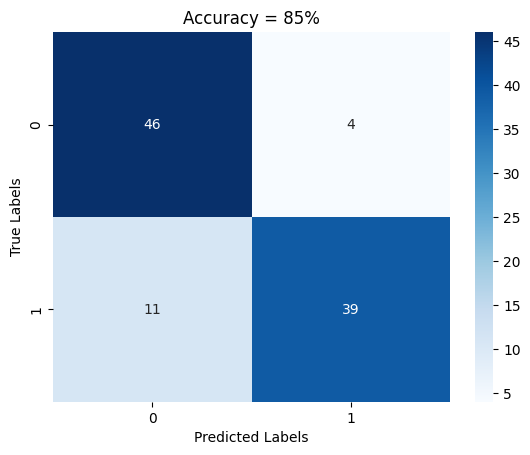

Completed in 4m 3s

TRIAL # 2

Clean traces: 25% complete
Clean traces: 50% complete
Clean traces: 75% complete
Clean traces: 100% complete


Infected traces: 25% complete
Infected traces: 50% complete
Infected traces: 75% complete
Infected traces: 100% complete




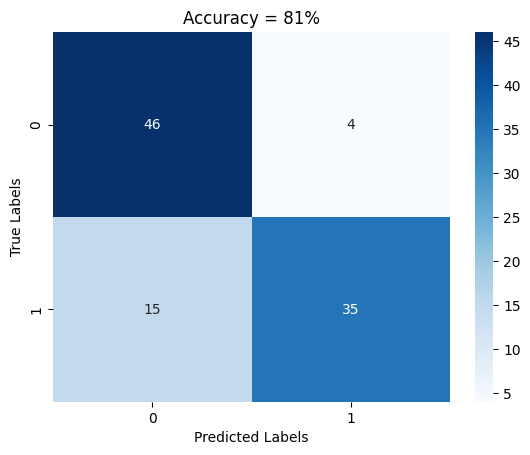

Completed in 8m 19s

TRIAL # 3

Clean traces: 25% complete
Clean traces: 50% complete
Clean traces: 75% complete
Clean traces: 100% complete


Infected traces: 25% complete
Infected traces: 50% complete
Infected traces: 75% complete
Infected traces: 100% complete




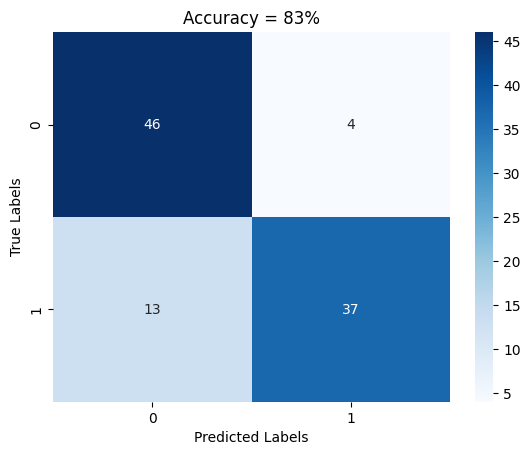

Completed in 4m 51s

TRIAL # 4

Clean traces: 25% complete
Clean traces: 50% complete
Clean traces: 75% complete
Clean traces: 100% complete


Infected traces: 25% complete
Infected traces: 50% complete
Infected traces: 75% complete
Infected traces: 100% complete




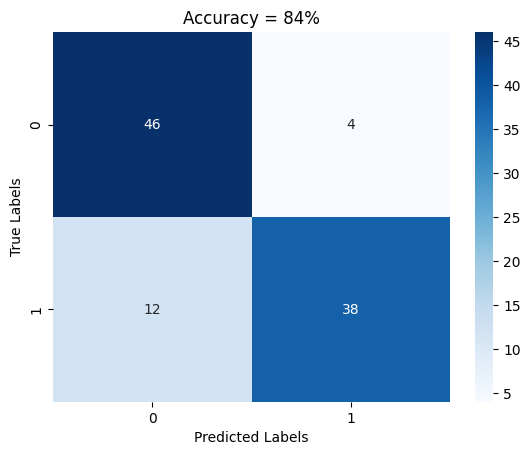

Completed in 3m 59s



In [99]:
SAMPLE_SIZE = int(.25*len(trace_files_clean))

n = CONTEXT_SIZE = 6
 
for trial in range(4):    
    print(f"TRIAL # {trial+1}\n")

    start_timer = time.time()
    
    clean_cnt = 0
    infected_cnt = 0
    trace_files_infected_idx = np.random.randint(len(trace_files_infected) - SAMPLE_SIZE + 1)
    
    # clean files in test partition
    counter = 0
    for clean_file in trace_files_clean[len(trace_files_clean)-SAMPLE_SIZE:]:
        counter += 1
        features, str_args, _ = process_trace(clean_folder, clean_file, syscall_type_mapping)
        prob1, prob2 = sequence_probability(features, str_args, n, syscall_to_cluster, transition_probabilities)
        if prob1 < 0.5 or prob2 < 0.5:
            clean_cnt += 1
        if counter % int(0.25*SAMPLE_SIZE) == 0:
            print(f'Clean traces: {counter//int(0.25*SAMPLE_SIZE)*25}% complete')
    
    print('\n')
    
    # infected files
    counter = 0
    for infected_file in trace_files_infected[trace_files_infected_idx:trace_files_infected_idx+SAMPLE_SIZE]:
        counter += 1
        features, str_args, _ = process_trace(infected_folder, infected_file, syscall_type_mapping)
        prob1, prob2 = sequence_probability(features, str_args, n, syscall_to_cluster, transition_probabilities)
        if prob1 < 0.5 or prob2 < 0.5:
            infected_cnt += 1
        if counter % int(0.25*SAMPLE_SIZE) == 0:
            print(f'Infected traces: {counter//int(0.25*SAMPLE_SIZE)*25}% complete')
    
    TP = infected_cnt
    FP = clean_cnt
    
    FN = SAMPLE_SIZE - infected_cnt
    TN = SAMPLE_SIZE - clean_cnt
    
    # label 1: infected
    # label 0: clean
    
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    
    conf_matrix = [[TN, FP], [FN, TP]]
    ACC = (TP + TN) / (TP + TN + FP + FN)
    
    print('\n')
    plt.figure()
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Accuracy = {math.floor(ACC*100)}%')
    
    plt.show();

    elapsed = time.time() - start_timer
    
    print(f"Completed in {int(elapsed//60)}m {int(elapsed%60)}s\n")